<a href="https://colab.research.google.com/github/micah-shull/LLMs/blob/main/LLM_051_huggingFace_RAG_HotpotQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## 🧠 Words → Vectors → Meaning Space

This idea is the **backbone of everything from GPT to RAG to recommendation systems.** When you embed text (words, sentences, paragraphs), you’re mapping it into a **high-dimensional space** — imagine a **giant cloud where similar ideas cluster together**.

### 📌 Example:

| Text | Location in Space |
|------|-------------------|
| `"I want a refund"` | ➡️ Close to `"Request a return"` |
| `"Where was Tesla born?"` | ➡️ Close to `"Birthplace of Nikola Tesla"` |
| `"I need help with setup"` | ➡️ Close to `"Installation instructions"` |

Even though these phrases use **different words**, embedding models like `sentence-transformers` are trained to **capture their meaning**.

> Think of it like turning language into **GPS coordinates for meaning**.

---

## 🔍 Why This Is So Powerful

- **Exact match search** is brittle: `"apply"` ≠ `"sign up"` ≠ `"register"`
- **Semantic search** solves that: all three are **close neighbors** in vector space

So in a RAG system, when someone types:
> “Can I return this?”

You don’t have to hope the KB says **"return"** — even if your article says:
> “Refunds can be issued within 30 days…”

The vector match will still connect the dots. ✨

---

## 📦 Embeddings Power Everything

| Use Case | How Embeddings Help |
|----------|---------------------|
| **Search** | Find similar content, not just exact words |
| **Chatbots** | Understand user intent across phrasing |
| **Recommendations** | Suggest similar items, reviews, or docs |
| **Clustering** | Group FAQs or topics by meaning |
| **RAG** | Retrieve the most relevant paragraphs for generation |



### 🔧 Step 1: Install Required Libraries


| Package              | Purpose |
|----------------------|---------|
| `transformers`       | LLMs like FLAN-T5 |
| `datasets`           | Load and manage `HotpotQA` |
| `sentence-transformers` | Create vector embeddings |
| `faiss-cpu`          | Fast vector similarity search |
| `python-dotenv`      | Manage your Hugging Face token securely |
| `huggingface_hub`    | Login and download models/data |
| `tqdm`               | Pretty progress bars |



In [4]:
# # 🔧 Environment + model access
# !pip install python-dotenv
# !pip install huggingface_hub
# !pip install transformers

# # 📦 Hugging Face datasets
# !pip install datasets

# # 💬 Sentence embeddings
# !pip install sentence-transformers

# # 🔍 Vector search
# !pip install faiss-cpu  # Use faiss-gpu if on GPU runtime

# # 📄 Optional: Progress bars and data cleaning
# !pip install tqdm


###  Step 2: Load Environment Variables + Login to Hugging Face

In [5]:
from huggingface_hub import login
from dotenv import load_dotenv
import os

# Load the .env file containing your token
load_dotenv("/content/HUGGINGFACE_HUB_TOKEN.env")

# Login using the token
login(token=os.environ["HUGGINGFACE_HUB_TOKEN"])

### 📚 Step 3: Load the HotpotQA Dataset


In [10]:
from datasets import load_dataset
import json
from termcolor import colored

# Load the HotpotQA dataset (fullwiki version includes large context)
dataset = load_dataset("hotpot_qa", "fullwiki", trust_remote_code=True)

# Get a sample
example = dataset["train"][0]

# what is it?
# print(type(example["context"]))
# print(example["context"])

example = dataset["train"][0]

# Question and answer
print(colored("📌 Question:", "cyan", attrs=["bold"]))
print(example["question"], "\n")

print(colored("✅ Answer:", "green", attrs=["bold"]))
print(example["answer"], "\n")

# Updated context printer
print(colored("📚 Context (Title → Paragraph):", "yellow", attrs=["bold"]))
titles = example["context"]["title"]
sentences = example["context"]["sentences"]

for title, sentence_list in zip(titles, sentences):
    paragraph = " ".join(sentence_list)
    print(f"📝 {title}:\n{paragraph}\n")

# Supporting facts
print(colored("🔎 Supporting Facts:", "magenta", attrs=["bold"]))
print(example["supporting_facts"])



📌 Question:
Which magazine was started first Arthur's Magazine or First for Women? 

✅ Answer:
Arthur's Magazine 

📚 Context (Title → Paragraph):
📝 Radio City (Indian radio station):
Radio City is India's first private FM radio station and was started on 3 July 2001.  It broadcasts on 91.1 (earlier 91.0 in most cities) megahertz from Mumbai (where it was started in 2004), Bengaluru (started first in 2001), Lucknow and New Delhi (since 2003).  It plays Hindi, English and regional songs.  It was launched in Hyderabad in March 2006, in Chennai on 7 July 2006 and in Visakhapatnam October 2007.  Radio City recently forayed into New Media in May 2008 with the launch of a music portal - PlanetRadiocity.com that offers music related news, videos, songs, and other music-related features.  The Radio station currently plays a mix of Hindi and Regional music.  Abraham Thomas is the CEO of the company.

📝 History of Albanian football:
Football in Albania existed before the Albanian Football Federat

### 🧹 Step 4: Extract Contexts and Build a Document Store

### 🔍 **What This Step Does**
This step prepares the **retrieval database** for RAG. We extract individual **context paragraphs** from the HotpotQA dataset so they can be embedded and indexed for semantic search.

Instead of relying on a static knowledge base, we dynamically build a **document store** from the dataset. This allows the model to later retrieve relevant information based on similarity to a user’s question.

---

### 🧠 **Why It's Important**
In a RAG pipeline:
- The **retriever** fetches relevant passages (in this case, context paragraphs)
- The **generator** uses them to answer the question

If the documents aren’t structured well, the retriever won’t perform effectively.


In [12]:
# Create a list of all documents (context paragraphs) for retrieval
docs = []
metadata = []

max_docs = 1000
processed = 0
skipped = 0

for example in dataset["train"]:
    if processed >= max_docs:
        break

    context = example.get("context", {})
    titles = context.get("title")
    sentences = context.get("sentences")

    if isinstance(titles, list) and isinstance(sentences, list):
        for title, sentence_list in zip(titles, sentences):
            paragraph = " ".join(sentence_list)
            docs.append(paragraph)
            metadata.append({"title": title})
        processed += 1
    else:
        skipped += 1

print(f"✅ Collected {len(docs)} paragraphs from {processed} examples. Skipped: {skipped}")


✅ Collected 9930 paragraphs from 1000 examples. Skipped: 0


Absolutely — this is one of the most powerful ideas behind RAG and modern search systems. Let's break it down in a clean, intuitive way for your documentation (and understanding):

---

## 🔍 What Does It Mean to "Embed and Index for Semantic Search"?

### 🧠 1. **Embedding**: Turn Text Into Meaningful Vectors

In traditional search (like CTRL+F or SQL `LIKE`), we match words **exactly**.

In **semantic search**, we want to match **meaning**, even if the words are different.

So we use **embedding models** like [`sentence-transformers`](https://www.sbert.net/) to convert each paragraph (or question) into a **vector** — a list of numbers that captures its meaning in multi-dimensional space.

Example:

| Text | Embedding |
|------|-----------|
| `"Tesla was born in Smiljan."` | `[0.12, -0.45, 0.88, ...]` |
| `"Where was Nikola Tesla born?"` | `[0.14, -0.42, 0.91, ...]` |

The closer these vectors are in space, the more similar the **meaning**.

---

### 🗂️ 2. **Indexing**: Make Searching Fast

Once we have all those vectors for your documents, we need to **store and organize** them so we can:
- Quickly compare any question vector to all document vectors
- Retrieve the **most similar matches** (i.e., relevant knowledge)

This is where **FAISS** (Facebook AI Similarity Search) comes in:
- It builds a **vector index**
- It supports **fast nearest neighbor search**
- You can ask: _"What are the 5 most similar paragraphs to this question?"_

---

### 🔄 In a RAG Pipeline

| Step | What Happens |
|------|--------------|
| 🔹 Embed your documents | Each doc is transformed into a vector |
| 🔹 Index them with FAISS | FAISS stores and organizes them for fast lookup |
| 🔹 Embed a new question | Transform the question into a vector |
| 🔹 Query FAISS | Find top-k matching document vectors |
| 🔹 Feed those docs to a generator | A model like FLAN-T5 uses them to answer the question |

---

### 🔧 Tools You’re Using

| Tool | Role |
|------|------|
| `sentence-transformers` | Create semantic embeddings |
| `faiss` | Search over embeddings |
| `transformers` | Generate answers based on the retrieved context |



# Visualize Embeddings

### ✅ Step 1: Import Plotting + Dimensionality Tools

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter
import numpy as np

from sentence_transformers import SentenceTransformer

### ✅ Step 2: Embed a Sample of Documents

In [14]:
# Use a small subset (100–300) to keep it fast
sample_size = 200
sample_docs = docs[:sample_size]
sample_titles = [m["title"] for m in metadata[:sample_size]]

# Embed them
embedder = SentenceTransformer("all-MiniLM-L6-v2")
doc_embeddings = embedder.encode(sample_docs, show_progress_bar=True)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

### ✅ Step 3: Reduce to 2D Using t-SNE or PCA

In [15]:
# Option A: Fast and linear
# reducer = PCA(n_components=2)

# Option B: Non-linear, better separation
reducer = TSNE(n_components=2, perplexity=30, random_state=42)

embeddings_2d = reducer.fit_transform(doc_embeddings)


### ✅ Step 4: Plot the Results

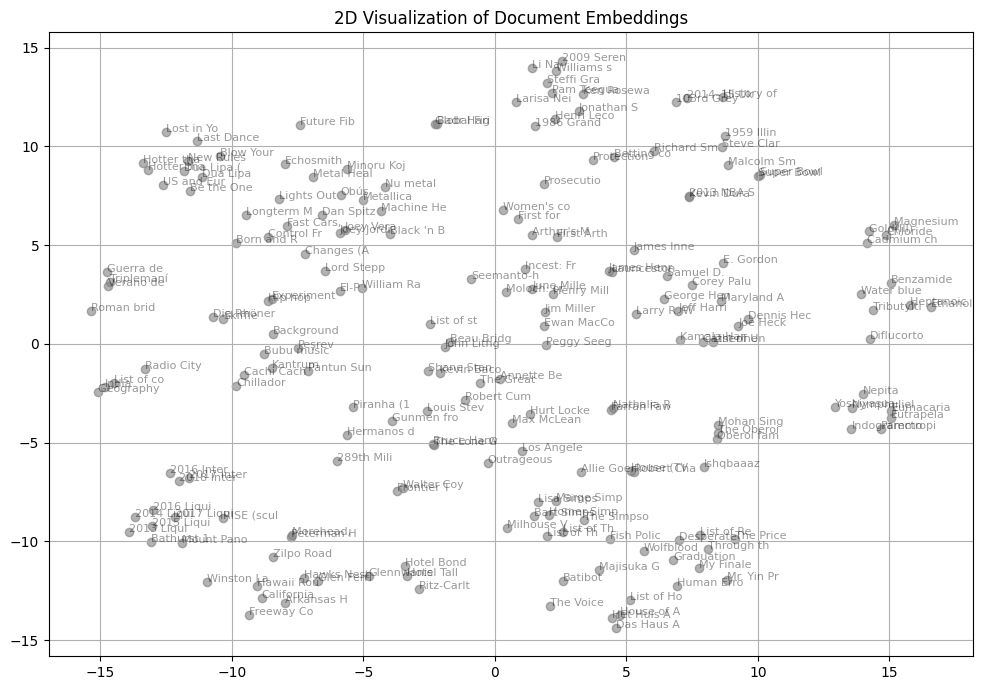

In [16]:
plt.figure(figsize=(10, 7))

# Optional: color by most common titles
top_titles = [t for t, count in Counter(sample_titles).items() if count > 2]
colors = ["red", "blue", "green", "orange", "purple", "brown", "teal"]

for i, (x, y) in enumerate(embeddings_2d):
    label = sample_titles[i]
    color = colors[top_titles.index(label)] if label in top_titles else "gray"
    plt.scatter(x, y, color=color, alpha=0.6)
    plt.text(x, y, label[:10], fontsize=8, alpha=0.4)  # optional: preview title

plt.title("2D Visualization of Document Embeddings")
plt.grid(True)
plt.tight_layout()
plt.show()



#### 🎨 Why Did the 2D Embedding Plot Appear All Gray?

### 🔍 **What Happened**
When visualizing the document embeddings from HotpotQA:
- Each document is tied to a **title** (e.g., "Nikola Tesla", "Arthur's Magazine")
- We attempted to color each dot by the **most frequent titles**
- But all dots appeared **gray**, meaning none of the titles in our sample were repeated enough to qualify as a top label

This is due to the nature of the dataset:
- **HotpotQA** contains a wide variety of unique topics across its entries
- In small samples (like 100–200 examples), it’s rare for a title to appear multiple times

---

### 🎯 **What Gray Represents**
In the code:
```python
color = colors[top_titles.index(label)] if label in top_titles else "gray"
```

- Any title **not in the top N most common** is assigned `"gray"`
- Because **no titles were common enough**, every point fell back to `"gray"`

---

### 📌 What This Tells Us
- The dataset is **diverse and well-distributed**, not dominated by a few topics
- This is actually useful in a RAG context — it means each document is likely **focused on a distinct fact or concept**, great for retrieval coverage

---

### ✅ In short:
> **All gray is normal and even desirable** when working with a diverse dataset like HotpotQA — it confirms that the topics are broad and non-redundant.

---

### 💼 Now imagine this was a company's documentation…

Let’s say you're building a RAG system for:
- A bank’s internal knowledge base  
- A SaaS product’s support center  
- A retail chain’s training manuals  

Then you'd likely see:

| Situation | What You’d See in the Plot |
|----------|-----------------------------|
| 📄 **Repeated topics** (e.g. "How to reset password") | Multiple documents clustered **closely together** |
| 🎯 **Overlapping answers** (e.g. billing vs refund policy) | Similar vectors → same region of the plot, same color |
| 🧩 **Shared terminology** ("account", "login", "error") | Higher density of **semantically similar documents** |
| 📚 **Internal categories** ("HR", "IT", "Support") | Clear, colorful clusters when visualized |

---

### 🌈 So yes — in a real business case:
- You’d likely see **fewer unique titles**
- Much more **overlap in content**
- And a lot more **color** in the plot
- Which helps identify **clusters**, redundancies, or gaps in knowledge

---

### 🧠 Bonus Insight:
You can even **use these plots to evaluate** your knowledge base:
- Are topics well-separated? ✅
- Is one area overrepresented? ⚠️
- Are there semantic holes in a certain category? 🔍

This is one of the *best use cases* of vector-based visualization — and now you know how to do it. Want to try plotting a few questions alongside the documents next to simulate real RAG retrieval?


# Building the Full RAG Loop

### ✅ Step 1: Embed a Sample Question + Retrieve Docs

## 🔍 Does the Model Embed Words or Chunks?

### ✅ **Answer: It embeds the entire question as one vector.**
You're using a **sentence transformer**, specifically:

```python
embedder = SentenceTransformer("all-MiniLM-L6-v2")
question_vec = embedder.encode([question])[0]
```

This model is trained to embed **whole sentences or paragraphs** into a single fixed-length vector (384 dimensions in this case).

> 🧠 **So it doesn’t embed individual words.**  
> Instead, it learns to capture the **meaning of the full sentence** in one vector.

That’s what makes sentence transformers perfect for semantic search and retrieval tasks like this.

---

## 🔁 Why Is `k = 3` Used in Retrieval?

```python
k = 3
D, I = index.search(np.array([question_vec]), k)
```

### ✅ **Answer: k controls how many documents we retrieve.**

- `k = 3` means we want the **top 3 most similar documents** (by vector similarity).
- You can think of this as **"How much context should we give the language model to answer with?"**

### 💡 Why not `k = 1` or `k = 10`?
| Value of `k` | Behavior |
|--------------|----------|
| `k = 1` | Fast, but might miss helpful info |
| `k = 3` | Balanced — enough to provide a grounded answer |
| `k = 10` | More thorough, but can include irrelevant or noisy info and may confuse the model |

> ⚠️ If you give too much context (like `k=20`), the model might **hallucinate or go off-topic** due to overload.

---

## 🧠 The Length of the Embeddings **Is Determined by the Model**

Every embedding model produces vectors of a **fixed dimension** depending on how the model was trained.

### 📏 Examples:

| Model Name                         | Embedding Dimension |
|-----------------------------------|---------------------|
| `all-MiniLM-L6-v2`                | **384**             |
| `all-mpnet-base-v2`               | **768**             |
| `bert-base-nli-mean-tokens`       | **768**             |
| `intfloat/e5-small-v2`            | **384**             |
| `intfloat/e5-large-v2`            | **1024**            |

> 💡 When you run: `len(doc_embeddings[0])` — you're actually discovering what that model is outputting.

---

## 🔧 Would the Setup Be Different With Another Model?

The **overall setup stays the same**, but a few things would change:

### ✅ What stays the same:
- You still embed documents
- You still index them with FAISS
- You still retrieve the top `k` neighbors

---

### ⚠️ What would change:
| Component | What You'd Need to Update |
|-----------|----------------------------|
| `embedding_dim` | Would be different (based on new model) |
| `SentenceTransformer()` | You'd load a different model name |
| FAISS index type | Still works with `IndexFlatL2`, but larger dimensions = more memory and slightly slower search |
| Retrieval quality | Different models perform better in different domains (e.g., code, legal, scientific) |



In [18]:
import faiss
import numpy as np

# Rebuild FAISS index from your existing embeddings
embedding_dim = len(doc_embeddings[0])
index = faiss.IndexFlatL2(embedding_dim)
index.add(np.array(doc_embeddings).astype("float32"))

# Embed a test question
question = "Where was Nikola Tesla born?"
question_vec = embedder.encode([question])[0].astype("float32")

# Retrieve top 3 matches
k = 3
D, I = index.search(np.array([question_vec]), k)

# Show retrieved docs
print(f"📌 Question: {question}\n")
for i in I[0]:
    print("📄 Retrieved Doc:\n", docs[i], "\n---")


📌 Question: Where was Nikola Tesla born?

📄 Retrieved Doc:
 Jonathan Stark (born April 3, 1971) is a former professional tennis player from the United States.  During his career he won two Grand Slam doubles titles (the 1994 French Open Men's Doubles and the 1995 Wimbledon Championships Mixed Doubles).  Stark reached the World No. 1 doubles ranking in 1994. 
---
📄 Retrieved Doc:
 Larry Richard Williams (born October 6, 1942) is an American author, stock and commodity trader, and politician from the state of Montana.  He is the father of four-time Academy Award and one-time Tony Award nominee actress Michelle Williams. 
---
📄 Retrieved Doc:
 John Arthur Lithgow ( ; born October 19 , 1945) is an American actor, musician, singer, comedian, voice actor, and author.  He has received two Tony Awards, six Emmy Awards, two Golden Globe Awards, three Screen Actors Guild Awards, an American Comedy Award, four Drama Desk Awards and has also been nominated for two Academy Awards and four Grammy Aw

### ✍️ Step 2: Generate a RAG Answer

In [19]:
from transformers import pipeline

# Load generation model
generator = pipeline("text2text-generation", model="google/flan-t5-base")

# Build context from top docs
retrieved = "\n".join([docs[i] for i in I[0]])

# Build prompt
prompt = f"""
You are a helpful assistant. Use the information below to answer the question.

Question: {question}
Context: {retrieved}

Answer:
"""

# Generate the response
response = generator(prompt.strip(), max_length=100, do_sample=False)[0]["generated_text"]
print("🤖 Answer:", response)


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cpu


🤖 Answer: the United States


In [20]:
import faiss
import numpy as np

# Rebuild FAISS index if needed
embedding_dim = len(doc_embeddings[0])
index = faiss.IndexFlatL2(embedding_dim)
index.add(np.array(doc_embeddings).astype("float32"))

# Retrieve top 3 docs
D, I = index.search(np.array([question_vec]), k=3)

# View them
for i in I[0]:
    print("📄 Retrieved Doc:\n", docs[i], "\n---")


📄 Retrieved Doc:
 Jonathan Stark (born April 3, 1971) is a former professional tennis player from the United States.  During his career he won two Grand Slam doubles titles (the 1994 French Open Men's Doubles and the 1995 Wimbledon Championships Mixed Doubles).  Stark reached the World No. 1 doubles ranking in 1994. 
---
📄 Retrieved Doc:
 Larry Richard Williams (born October 6, 1942) is an American author, stock and commodity trader, and politician from the state of Montana.  He is the father of four-time Academy Award and one-time Tony Award nominee actress Michelle Williams. 
---
📄 Retrieved Doc:
 John Arthur Lithgow ( ; born October 19 , 1945) is an American actor, musician, singer, comedian, voice actor, and author.  He has received two Tony Awards, six Emmy Awards, two Golden Globe Awards, three Screen Actors Guild Awards, an American Comedy Award, four Drama Desk Awards and has also been nominated for two Academy Awards and four Grammy Awards.  Lithgow has received a star on the 

### ✅ Define the RAG Function

In [23]:
# ✅ RAG-style QA Function
def rag_qa(question, embedder, index, docs, generator, top_k=3, max_tokens=100, debug=False):
    """
    Runs a full RAG query: embed question → retrieve context → generate answer.

    Args:
        question (str): The user's input question.
        embedder: A sentence-transformers model.
        index: A FAISS index containing document embeddings.
        docs (list): List of paragraph documents.
        generator: A Hugging Face text2text-generation pipeline.
        top_k (int): How many documents to retrieve.
        max_tokens (int): Max tokens to generate in the answer.
        debug (bool): Whether to print internal steps.

    Returns:
        dict: Question, retrieved docs, and generated answer.
    """
    # Embed the question
    q_vector = embedder.encode([question])[0].astype("float32")

    # Retrieve top-k docs
    D, I = index.search(np.array([q_vector]), top_k)
    retrieved_docs = [docs[i] for i in I[0]]

    # Build the prompt
    context = "\n".join(retrieved_docs)
    prompt = f"""
    You are a helpful assistant. Use the information below to answer the question.

    Question: {question}
    Context: {context}

    Answer:
    """

    # Generate the answer
    answer = generator(prompt.strip(), max_length=max_tokens, do_sample=False)[0]["generated_text"]

    if debug:
        print("📌 Question:", question)
        print("📚 Retrieved Context:\n", context[:500], "...\n")  # Preview first 500 chars
        print("🤖 Answer:", answer)
        print("-" * 60)

    return {
        "question": question,
        "context": context,
        "answer": answer
    }


#### ✅ Example: Run It on a Question

In [22]:
result = rag_qa(
    question="Where was Nikola Tesla born?",
    embedder=embedder,
    index=index,
    docs=docs,
    generator=generator,
    debug=True
)


📌 Question: Where was Nikola Tesla born?
📚 Retrieved Context:
 Jonathan Stark (born April 3, 1971) is a former professional tennis player from the United States.  During his career he won two Grand Slam doubles titles (the 1994 French Open Men's Doubles and the 1995 Wimbledon Championships Mixed Doubles).  Stark reached the World No. 1 doubles ranking in 1994.
Larry Richard Williams (born October 6, 1942) is an American author, stock and commodity trader, and politician from the state of Montana.  He is the father of four-time Academy Award and one-time Ton ...

🤖 Answer: the United States
------------------------------------------------------------


#### 🚀 Bonus: Test Multiple Questions

In [25]:
questions = [
    "Where was Nikola Tesla born?",
    "What is Arthur's Magazine?",
    "When was First for Women founded?",
    "Who founded Echosmith?",
]

for q in questions:
    rag_qa(q, embedder, index, docs, generator, debug=True)


📌 Question: Where was Nikola Tesla born?
📚 Retrieved Context:
 Jonathan Stark (born April 3, 1971) is a former professional tennis player from the United States.  During his career he won two Grand Slam doubles titles (the 1994 French Open Men's Doubles and the 1995 Wimbledon Championships Mixed Doubles).  Stark reached the World No. 1 doubles ranking in 1994.
Larry Richard Williams (born October 6, 1942) is an American author, stock and commodity trader, and politician from the state of Montana.  He is the father of four-time Academy Award and one-time Ton ...

🤖 Answer: the United States
------------------------------------------------------------
📌 Question: What is Arthur's Magazine?
📚 Retrieved Context:
 Arthur's Magazine (1844–1846) was an American literary periodical published in Philadelphia in the 19th century.  Edited by T.S. Arthur, it featured work by Edgar A. Poe, J.H. Ingraham, Sarah Josepha Hale, Thomas G. Spear, and others.  In May 1846 it was merged into "Godey's Lady'

#### Remove Widgets from Notebook to save to Github

In [28]:
import json
from google.colab import drive
drive.mount('/content/drive')

# Path to your current notebook file (adjust if different)
notebook_path = "/content/drive/My Drive/LLM/LLM_051_huggingFace_RAG_HotpotQA.ipynb"


# Load the notebook JSON
with open(notebook_path, 'r', encoding='utf-8') as f:
    nb = json.load(f)

# Remove the widget metadata if it exists
if 'widgets' in nb.get('metadata', {}):
    del nb['metadata']['widgets']

# Save the cleaned notebook
with open(notebook_path, 'w', encoding='utf-8') as f:
    json.dump(nb, f, indent=2)

print("Notebook metadata cleaned. Try saving to GitHub again.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Notebook metadata cleaned. Try saving to GitHub again.
